In [1]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('chesterish')

In [2]:
import pandas as pd
import numpy as np
import string 
#import os
#import json
from pprint import pprint
#from copy import deepcopy
from tqdm.notebook import tqdm 
import pickle
pd.set_option('display.max_columns', 9000)
import matplotlib.pyplot as plt
import statistics as stats

from sklearn.feature_extraction.text import CountVectorizer
import nltk
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('wordnet')
#nltk.download('stopwords')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
         return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
        
from wordcloud import WordCloud
from gensim import matutils, models, corpora
import scipy.sparse
import gensim
import re

In [3]:
#meta_data = pd.read_csv('../all_sources_metadata_2020-03-13.csv')
#biorxiv = pd.read_csv('../biorxiv_clean.csv')
clean_comm = pd.read_csv('../clean_comm_use.csv')
#clean_noncomm = pd.read_csv('../clean_noncomm_use.csv')
#pmc = pd.read_csv('../clean_pmc.csv')
organs = pd.read_csv('organs.csv', header = None, names = ['Organ'])

In [4]:
###Make doc word matrix
docs = pd.DataFrame(clean_comm[['text','title', 'authors', 'paper_id']])
##Remove punctuation
docs['text_rm'] = docs['text'].map(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

#token_list = [nltk.word_tokenize(docs['text'][i]) for i,line in enumerate(docs['text'])


In [5]:
#pickle.dump(token_list, open( "clean_comm_tokens.p", "wb" ) )

In [6]:
#comm_token_list = pickle.load(open('clean_comm_tokens.p', 'rb'))

In [7]:
stop_words = set(stopwords.words('english')) 
stop_words = list(stop_words) + ['however', 'Results', 'Introduction', 'Conclusion', 'method', 
                                 'also', 'result', 'methods']
#lem = WordNetLemmatizer()
#stop_words_list = [lem.lemmatize(word) for word in stop_words]

#vect = CountVectorizer(tokenizer=LemmaTokenizer(), stop_words=stop_words_list, analyzer='word')
#words = vect.fit(docs['text_rm'])

#pickle.dump(words, open('comm_Countvec.p', 'wb'))
words = pickle.load(open('comm_Countvec.p', 'rb'))
#words_transform = words.transform(docs['text_rm'])
#pickle.dump(words_transform, open('words_transform.p', 'wb'))

In [8]:
words_transform = pickle.load(open('../words_transform.p', 'rb'))
sorted_wordCount = words_transform.toarray()
feature_names = np.array(words.get_feature_names())


In [9]:
##Check if this makes sense
comm_df = pd.DataFrame(sorted_wordCount, columns = feature_names).T
comm_df.columns = [docs['paper_id']]



In [10]:
covid_terms = ['covid', 'covid-19', 'sars-cov-2', '2019-ncov', 'coronavirus']
ards_terms = ['ards', 'virus', 'viral', 'uri', 'pulmonary']
organ_terms = organs
relevant_ards_organs = ['lungs', 'pulmonary', 'heart', 'cardio', 'intestine', 'kidney','renal', 'brain',
                       'thecal']
outcomes = ['sepsis', 'edema', 'coma', 'stroke', 'death', 'deceased', 'failure', 'multisystem',
           'alveolar', 'infiltrate', 'ventilator', 'ICU', 'bipap', 'bi-pap', 'cpap', 'congestion',
           'fibrosis', 'pna', 'pneumonia', 'barotrauma', 'nosocomial', 'neuromyopathy', 'sleep',
           'delirium', 'thrombosis', 'bleed', 'GI', 'nutrition', 'mortality', 'morbidity']

age = ['year', 'age']


In [11]:
comm_ards_df = comm_df.loc[ards_terms + age].T.sort_values(by=['ards','viral','age'],
                                                           ascending=False)
#pickle.dump(comm_ards_filter_df, open( "ards_df.p", "wb" ) )

In [12]:
filter1 = comm_ards_df[(comm_ards_df['ards']>10)] 

filter2 = comm_ards_df[(comm_ards_df['ards']>10) & (comm_ards_df['age']>0)]

comm_ards_filter_3 = comm_ards_df[(comm_ards_df['ards']>10) & (comm_ards_df['age']>0)
                                  & ( (comm_ards_df['viral']>0) | (comm_ards_df['virus']>0) )] 

###Make paper_id-text dict###
id_text_dict = pd.DataFrame(docs['text_rm'].values,
                               index = docs['paper_id'].values).to_dict(orient='index')


In [13]:
##Get avg length of each text
paper_ids = comm_ards_filter_3.reset_index()['paper_id'].tolist()
avg_words = comm_df[paper_ids].sum().mean()

##Avg number of times that ARDS is mentioned
avg_ards = comm_ards_filter_3['ards'].mean()

#avg_len = [len(str((id_text_dict[text]))) for text in comm_ards_filter_3.reset_index()['paper_id']]
###Avg length of string, maybe get word count is better
#stats.mean(avg_len)


In [14]:
#comm_ards_filter_df = pickle.load(open('ards_df.p', 'rb'))


No handles with labels found to put in legend.


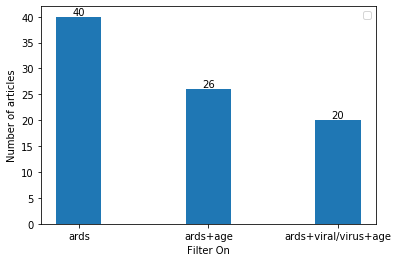

In [15]:
labels = ['ards', 'ards+age', 'ards+viral/virus+age']
articles = [len(filter1), len(filter2), len(comm_ards_filter_3)]
x = np.arange(len(labels))
width= 0.35

fig, ax = plt.subplots()
rect = ax.bar(x, articles, width)

ax.set_ylabel('Number of articles')
ax.set_xlabel('Filter On')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

###Source from matplotlib page###
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rect)
plt.show()


No handles with labels found to put in legend.


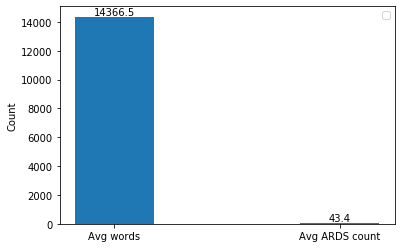

In [16]:
labels = ['Avg words', 'Avg ARDS count']
articles = [avg_words, avg_ards]
x = np.arange(len(labels))
width= 0.35

fig, ax = plt.subplots()
rect = ax.bar(x, articles, width)

ax.set_ylabel('Count')
ax.set_xlabel('')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rect)
plt.show()

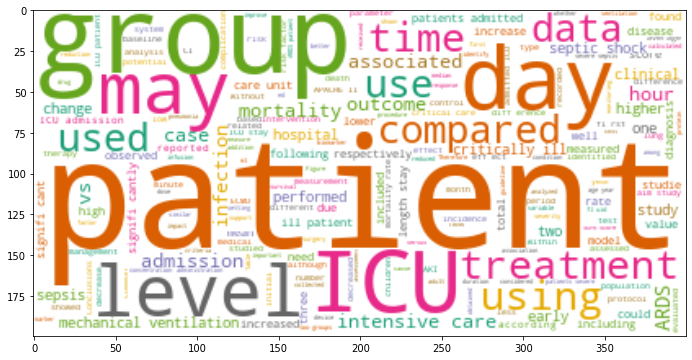

In [17]:
####Word Clouds####
##modified from pyohio 

text_list = [str(id_text_dict[text]) for text in comm_ards_filter_3.reset_index()['paper_id']]

text_str = ''.join(text_list); len(text_str)

wc = WordCloud(stopwords=stop_words, background_color='white', colormap='Dark2', max_font_size=150)
plt.rcParams['figure.figsize'] = [16,6]

wc.generate(text_str)
plt.subplot()
plt.imshow(wc, interpolation='bilinear')
plt.show()

In [18]:
###Topic modeling###
### comm_df[paper_ids] term-document matrix
sparse_counts = scipy.sparse.csr_matrix(comm_df[paper_ids])
corpus = matutils.Sparse2Corpus(sparse_counts)
id2word = dict((v,k) for k, v in words.vocabulary_.items())

In [19]:
#lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=4, passes=2)
#lda.print_topics()
lda = pickle.load(open('lda.p', 'rb'))

In [20]:
corpus_transformed = lda[corpus]
list(zip([a for [(a,b)] in corpus_transformed], comm_df))

[(0, ('000b7d1517ceebb34e1e3e817695b6de03e2fa78',)),
 (0, ('00142f93c18b07350be89e96372d240372437ed9',)),
 (0, ('0022796bb2112abd2e6423ba2d57751db06049fb',)),
 (0, ('00326efcca0852dc6e39dc6b7786267e1bc4f194',)),
 (0, ('00352a58c8766861effed18a4b079d1683fec2ec',)),
 (0, ('0043d044273b8eb1585d3a66061e9b4e03edc062',)),
 (0, ('0049ba8861864506e1e8559e7815f4de8b03dbed',)),
 (0, ('00623bf2715e25d3acacb3f210d6888ed840e3cb',)),
 (0, ('0072159e1ebecc889e9bcabb58bb45c47e18a403',)),
 (0, ('007618ad76a3548195ab5d11c1e2459931c91cd1',)),
 (0, ('007bf75961da42a7e0cc8e2855e5c208a5ec65c1',)),
 (0, ('0080d3bd9fb92e022c27715c2d1249042aa998b8',)),
 (0, ('0089aa4b17549b9774f13a9e2e12a84fc827d60b',)),
 (0, ('008c1ceaeffe7abc87b031af39fae2632fa72897',)),
 (0, ('008d980cbcc283a9b707de3d9a02573dde8528ac',)),
 (0, ('009002e8a66b8c1df088cf04069629fd76b13bb9',)),
 (0, ('0093f9ae0861afc0d29fff935ae6a3af898cea00',)),
 (0, ('0094b25e2500306fadbdfb41d520f2970bb086d3',)),
 (0, ('00951716e01c8e0cc341770389fc38d1b545521

In [21]:
#import pyLDAvis.gensim

#comm_list = comm_df[paper_ids].index.tolist()
#comm_tokens = [nltk.word_tokenize(word) for word in tqdm(comm_list)]

##Make dictionary 
#dictionary = corpora.Dictionary(comm_tokens)
#corpus = [dictionary.doc2bow(text) for text in tqdm(comm_tokens)]
#lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, mds = 'mmds', sort_topics=False)
#pickle.dump(lda_display, open('lda_display.p', 'wb'))
#pyLDAvis.display(lda_display)


In [126]:
#info_list = [re.findall(r"([ \w]{,100} (?:ards|viral|virus) [\w ]{,100})",text_list[i].lower()) for
#             i,row in enumerate(text_list)]

#organ_list = [re.findall(r"([ \w]{,100} (?:Bone|Carpus|clavicle|femur|Fibula|Humerus|Mandible|Metacarpus|Metatarsus|Ossicles|Patella|Phalanges|Radius|Skull|Tarsus|Tibia|Ulna|Rib|Vertebra|Pelvis|Sternum|Cartilage|Fibrous joint|Cartilaginous joint|Synovial joint|Muscle|Tendon|Diaphragm|Artery|Vein|Lymphatic vessel|Heart|Bone marrow|Thymus|Spleen|Lymph node|Brain|Spinal cord|Nerve|Ear|Eye|Skin|Subcutaneous tissue|Breast|Mammary gland|Myeloid|Lymphoid|Upper|Nose|Nasopharynx|Larynx|Lower|Trachea|Bronchus|Lung|Mouth|Salivary gland|Tongue|Lips|Oropharynx|Laryngopharynx|Esophagus|Stomach|Small intestine|Appendix|Colon|Rectum|Anus|accessory|Liver|Biliary tract|Pancreas|Kidney|Ureter|Bladder|Urethra|Male|Scrotum|Penis|Size|Prostate|Testicle|Seminal vesicle|Female|Uterus|Vagina|Vulva|Ovary|Placenta|Pituitary|Pineal|Thyroid|Parathyroid|Adrenal|Islets of Langerhans) [\w ]{,100})",
#                         text_list[i].lower()) for i,row in enumerate(text_list)]

#outcome_list = [re.findall(r"([ \w]{,100} (?:sepsis|edema|coma|stroke|death|deceased|failure|multisystem|alveolar|infiltrate|ventilator|ICU|bipap|bi-pap|cpap|congestion|fibrosis|pna|pneumonia|barotrauma|nosocomial|neuromyopathy|sleep|delirium|thrombosis|bleed|GI|nutrition|mortality|morbidity) [\w ]{,100})",
#                           text_list[i].lower()) for i,row in enumerate(text_list)]

In [25]:
#print(*organ_terms['Organ'].values,sep='|')
#print(*outcomes, sep='|')

info_list_df = pd.Series(info_list, index = paper_ids)

In [123]:
df_summary = pd.DataFrame(
    {'Info' :info_list,
     'Organ Involved' :organ_list,
     'Outcomes' :outcome_list
    }, index = paper_ids
     )

In [125]:
df_summary.to_csv('CORD.csv')

In [124]:
df_summary

,Info,Organ Involved,Outcomes
7516383abbd16005d507e7fb5bb6766a8b0f5894,nacute respiratory distress syndrome ards is d...,[],[ome ards is due to an increase in the pulmona...
5a6330a739f18fd6bc502bd9b59de55e8c081d4e,nacute respiratory distress syndrome ards is d...,[al change this study demonstrates that applic...,[s without risk factors to determine whether t...
c848bce30b9e60bccfd15a5534af1d0cea54c686,nacute respiratory distress syndrome ards is d...,[],[ires mechanical ventilation and admission to ...
364f3e45183f362e8398724c29d3b010436ce375,nacute respiratory distress syndrome ards is d...,[],[nare based on prior definitions clinically ar...
0792384d074cef963c808eacf3c63e3654776a2a,nacute respiratory distress syndrome ards is d...,[],[ 100000 children for all causes of aliards wi...
1f63075aa219ae29132b49a0c7277632b9b31ba8,nacute respiratory distress syndrome ards is d...,[e examined at the level of cricoid cartilage ...,[duction healthy bowel function is an importan...
8ed6b522481e264a5d691f7f5fbd5d142b5f82f7,nacute respiratory distress syndrome ards is d...,[],[st imaging and severe hypoxemia 1 the severi...
bb8a05062237c64d231f3ba922b8ec26c7f32eaa,nacute respiratory distress syndrome ards is d...,[],[culture were liver cirrhosis haematological m...
792417a1bbb50a19ce96e8354aa9f16f2424b850,nacute respiratory distress syndrome ards is d...,[],[ 5introduction traditional whole blood experi...
5df3884ac512e1ad4cedd33f5e83b09a9cfa5668,nacute respiratory distress syndrome ards is d...,[],[s characterized by pulmonary inflammation tha...


In [28]:
pd.Series(info_list[0], index = np.repeat(paper_ids[0], len(info_list[0])))


7516383abbd16005d507e7fb5bb6766a8b0f5894    nacute respiratory distress syndrome ards is d...
7516383abbd16005d507e7fb5bb6766a8b0f5894     deletion in the promoter of nfkb1 is associat...
7516383abbd16005d507e7fb5bb6766a8b0f5894    ome has a higher incidence and mortality in ol...
7516383abbd16005d507e7fb5bb6766a8b0f5894    rain injury 17  recent epidemiological studies...
7516383abbd16005d507e7fb5bb6766a8b0f5894    isease immunosuppression hypoalbuminemia and o...
                                                                  ...                        
7516383abbd16005d507e7fb5bb6766a8b0f5894    ni early recognition of ards modified risk fac...
7516383abbd16005d507e7fb5bb6766a8b0f5894    tensive clinical laboratory and imaging evalua...
7516383abbd16005d507e7fb5bb6766a8b0f5894     severity of ards and planning a careful treat...
7516383abbd16005d507e7fb5bb6766a8b0f5894     recruitment maneuvers with adequate peep titr...
7516383abbd16005d507e7fb5bb6766a8b0f5894    nd response to i

In [140]:
def fix_list_columns(values, index):
    
    final_series = []
    
    for i in range(len(values)):
        series_list = [pd.Series(values[i][j], index = np.repeat(index[j], len(values[i][j])))
                      for j, row in enumerate(values[i])]
        final_series[i] = pd.concat(series_list)
    
    return pd.concat(final_series, axis=1, keys=[s.name for s in final_series])

In [141]:
test = fix_list_columns([info_list, organ_list], paper_ids)

info_series = fix_list_columns(info_list, paper_ids)
organ_series = fix_list_columns(organ_list, paper_ids)
outcomes_series = fix_list_columns(outcome_list, paper_ids)



IndexError: list assignment index out of range

In [109]:
x = x.reset_index()
x.columns = ['index', 'text']
x = x.groupby('index').apply(pd.unique(x['index']))

TypeError: unhashable type: 'numpy.ndarray'

In [135]:
test = [[1,2],[3,4]]

In [139]:
test[1]

[3, 4]

In [118]:
info_series.index = info_series.index.drop_duplicates()

ValueError: Length mismatch: Expected axis has 908 elements, new values have 20 elements

7516383abbd16005d507e7fb5bb6766a8b0f5894    nacute respiratory distress syndrome ards is d...
7516383abbd16005d507e7fb5bb6766a8b0f5894     deletion in the promoter of nfkb1 is associat...
7516383abbd16005d507e7fb5bb6766a8b0f5894    ome has a higher incidence and mortality in ol...
7516383abbd16005d507e7fb5bb6766a8b0f5894    rain injury 17  recent epidemiological studies...
7516383abbd16005d507e7fb5bb6766a8b0f5894    isease immunosuppression hypoalbuminemia and o...
                                                                  ...                        
5dc0b8b662824323881c3a1ae3a1bae2a821484d    ated lung injury in any stage of illness parti...
5dc0b8b662824323881c3a1ae3a1bae2a821484d    ch are found naturally in human blood the who ...
5dc0b8b662824323881c3a1ae3a1bae2a821484d    n those patients who developed the dangerous c...
5dc0b8b662824323881c3a1ae3a1bae2a821484d    lly predefined selection criteria they found 5...
5dc0b8b662824323881c3a1ae3a1bae2a821484d     no cases of sar